In [13]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler


In [14]:

# -----------------------------
# 1. Hyperparameter Optimization Function
# -----------------------------

def optimize_hyperparameters(X_train, y_train):
    # Parameter grids for RF and DT
    param_grid_rf = {
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [None, 1, 3, 5, 7, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 15, 20]
    }
    param_grid_dt = {
        'max_depth': [None, 1, 3, 5, 7, 10, 15, 20, 30],
        'min_samples_split': [2, 5, 10, 15, 20, 30, 50]
    }
    
    cv_split = TimeSeriesSplit(n_splits=3)
    
    dt_search = RandomizedSearchCV(
        DecisionTreeRegressor(random_state=42),
        param_grid_dt, n_iter=10, cv=cv_split, scoring='neg_root_mean_squared_error', 
        n_jobs=-1, random_state=42
    )
    rf_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid_rf, n_iter=10, cv=cv_split, scoring='neg_root_mean_squared_error', 
        n_jobs=-1, random_state=42
    )
    
    dt_search.fit(X_train, y_train)
    rf_search.fit(X_train, y_train)
    
    return dt_search, rf_search

In [15]:
# -----------------------------
# 2. Baseline and Persistence Models
# -----------------------------

def baseline_predictions(past_targets, n_samples=100, n_test=0):
    if len(past_targets) == 0:
        return np.zeros(n_test)
    sample_dist = np.random.choice(past_targets, size=n_samples, replace=True)
    return np.array([np.random.choice(sample_dist) for _ in range(n_test)])

def persistence_predictions(n_test):
    return np.zeros(n_test)

In [16]:
# -----------------------------
# 3. Training, Evaluation and Candidate Predictions
# -----------------------------
def train_and_evaluate(country, past_data, new_data, features, target):
    # Data preprocessing
    past_data = past_data.copy()
    new_data = new_data.copy()
    
    past_data['snapshot_date'] = pd.to_datetime(past_data['snapshot_date'])
    new_data['snapshot_date'] = pd.to_datetime(new_data['snapshot_date'])
    past_data.sort_values(by="snapshot_date", inplace=True)
    new_data.sort_values(by="snapshot_date", inplace=True)
    
    # Filter records with age <= 10
    past_data = past_data[past_data['age'] <= 10]
    new_data = new_data[new_data['age'] <= 10]
    
    X_train, y_train = past_data[features], past_data[target]
    X_test, y_test = new_data[features], new_data[target]
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Hyperparameter tuning
    dt_search, rf_search = optimize_hyperparameters(X_train_scaled, y_train)
    best_dt_params = dt_search.best_params_
    best_rf_params = rf_search.best_params_
    
    # Train best models
    dt_model = DecisionTreeRegressor(**best_dt_params, random_state=42)
    rf_model = RandomForestRegressor(**best_rf_params, random_state=42, n_jobs=-1)
    dt_model.fit(X_train_scaled, y_train)
    rf_model.fit(X_train_scaled, y_train)
    
    y_pred_dt = dt_model.predict(X_test_scaled)
    y_pred_rf = rf_model.predict(X_test_scaled)
    
    past_targets = past_data[target].values
    baseline_pred = baseline_predictions(past_targets, n_samples=100, n_test=len(y_test))
    persistence_pred = persistence_predictions(n_test=len(y_test))
    
    # Filter out records with target value 0
    mask = y_test != 0
    y_test_filt = y_test[mask]
    y_pred_dt_filt = y_pred_dt[mask]
    y_pred_rf_filt = y_pred_rf[mask]
    
    # Calculate RMSE (for debugging purposes)
    rmse_dt = np.sqrt(mean_squared_error(y_test_filt, y_pred_dt_filt))
    rmse_rf = np.sqrt(mean_squared_error(y_test_filt, y_pred_rf_filt))
    rmse_baseline = np.sqrt(mean_squared_error(y_test_filt, baseline_pred[mask]))
    rmse_persistence = np.sqrt(mean_squared_error(y_test_filt, persistence_pred[mask]))
    
    print(f"{country}: DT RMSE: {rmse_dt:.4f} | RF RMSE: {rmse_rf:.4f} | Baseline RMSE: {rmse_baseline:.4f} | Persistence RMSE: {rmse_persistence:.4f}")
    
    # ---- Extract candidate predictions ----
    dt_candidates = dt_search.cv_results_['params']
    rf_candidates = rf_search.cv_results_['params']
    
    dt_candidate_predictions = []
    dt_candidate_params = []
    rf_candidate_predictions = []
    rf_candidate_params = []
    
    # For Decision Tree candidates
    for params in dt_candidates:
        model = DecisionTreeRegressor(**params, random_state=42)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)[mask]
        dt_candidate_predictions.append(pred)
        dt_candidate_params.append(params)
        
    # For Random Forest candidates
    for params in rf_candidates:
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)[mask]
        rf_candidate_predictions.append(pred)
        rf_candidate_params.append(params)
    
    return {
        "y_test": y_test_filt,
        "y_pred_dt": y_pred_dt_filt,
        "y_pred_rf": y_pred_rf_filt,
        "rmse_dt": rmse_dt,
        "rmse_rf": rmse_rf,
        "dt_candidate_params": dt_candidate_params,
        "dt_candidate_predictions": dt_candidate_predictions,
        "rf_candidate_params": rf_candidate_params,
        "rf_candidate_predictions": rf_candidate_predictions
    }


In [17]:
# -----------------------------
# 4. Plot Best Models
# -----------------------------

def plot_best_models(countries, y_tests, y_preds_rf, y_preds_dt):
    for country in countries:
        if country not in y_tests or y_tests[country].size == 0:
            print(f"⚠️ No test data available for {country}. Skipping plot.")
            continue
        
        y_test = y_tests[country]
        y_pred_rf = y_preds_rf[country]
        y_pred_dt = y_preds_dt[country]

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Best Random Forest plot
        axes[0].scatter(y_test, y_pred_rf, alpha=0.6, color='dodgerblue',
                        label=f"RF R2: {np.corrcoef(y_test, y_pred_rf)[0,1]:.2f}")
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[0].set_title(f'{country} - RF')
        axes[0].set_xlabel("Actual Value")
        axes[0].set_ylabel("Predicted Value")
        axes[0].legend()
        axes[0].grid(True)

        # Best Decision Tree plot
        axes[1].scatter(y_test, y_pred_dt, alpha=0.6, color='dodgerblue',
                        label=f"DT R2: {np.corrcoef(y_test, y_pred_dt)[0,1]:.2f}")
        axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[1].set_title(f'{country} - DT')
        axes[1].set_xlabel("Actual Value")
        axes[1].set_ylabel("Predicted Value")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()


In [18]:
# -----------------------------
# 5. Plot Candidate Models
# -----------------------------
def plot_candidate_models(model_type, candidate_params, candidate_predictions, y_test):

    n_candidates = len(candidate_params)
    n_cols = 3
    n_rows = math.ceil(n_candidates / n_cols)
    
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    plt.suptitle(f"{model_type} Candidate Models", fontsize=12)
    
    for i, params in enumerate(candidate_params):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        pred = candidate_predictions[i]
        ax.scatter(y_test, pred, alpha=0.6, color='dodgerblue')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax.set_xlabel("Actual Value")
        ax.set_ylabel("Predicted Value")
        ax.grid(True)
        
        # Set subplot title to display parameter combination
        ax.set_title(f"{params}", fontsize=8)
        
        # Calculate R² 
        r2 = np.corrcoef(y_test, pred)[0,1]
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, f"R2: {r2:.2f}", transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

FR: DT RMSE: 8.3434 | RF RMSE: 7.9827 | Baseline RMSE: 16.1871 | Persistence RMSE: 16.2201


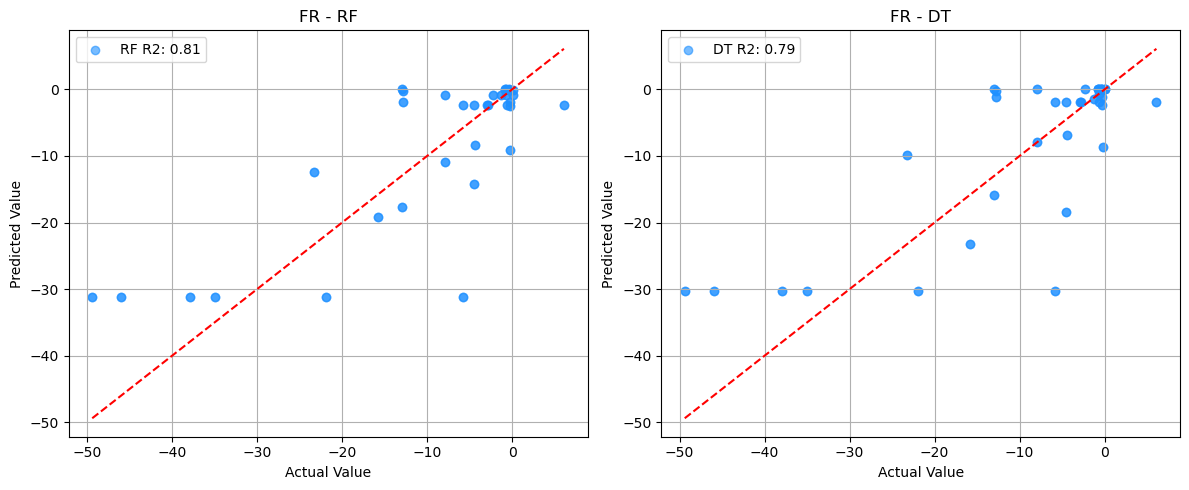

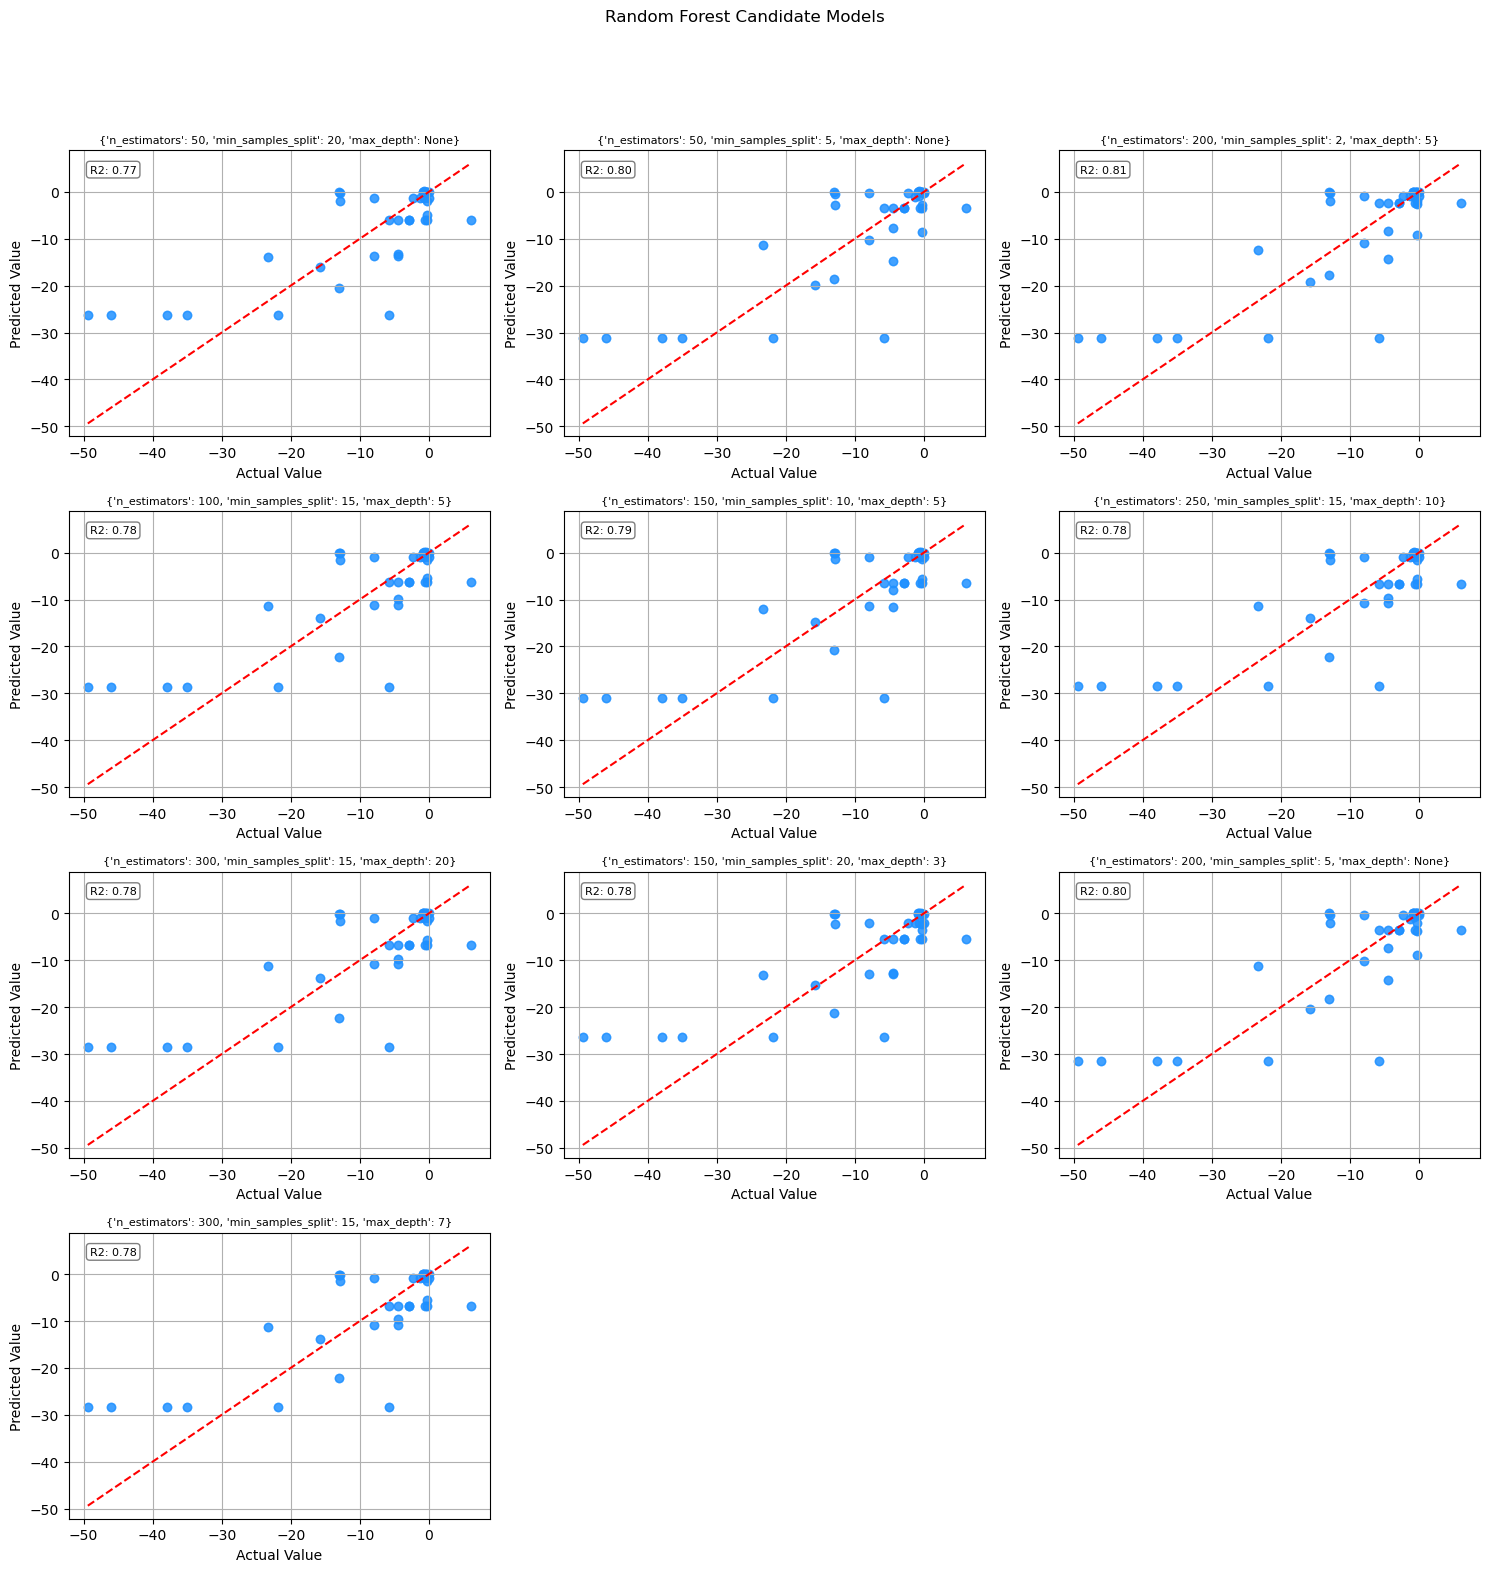

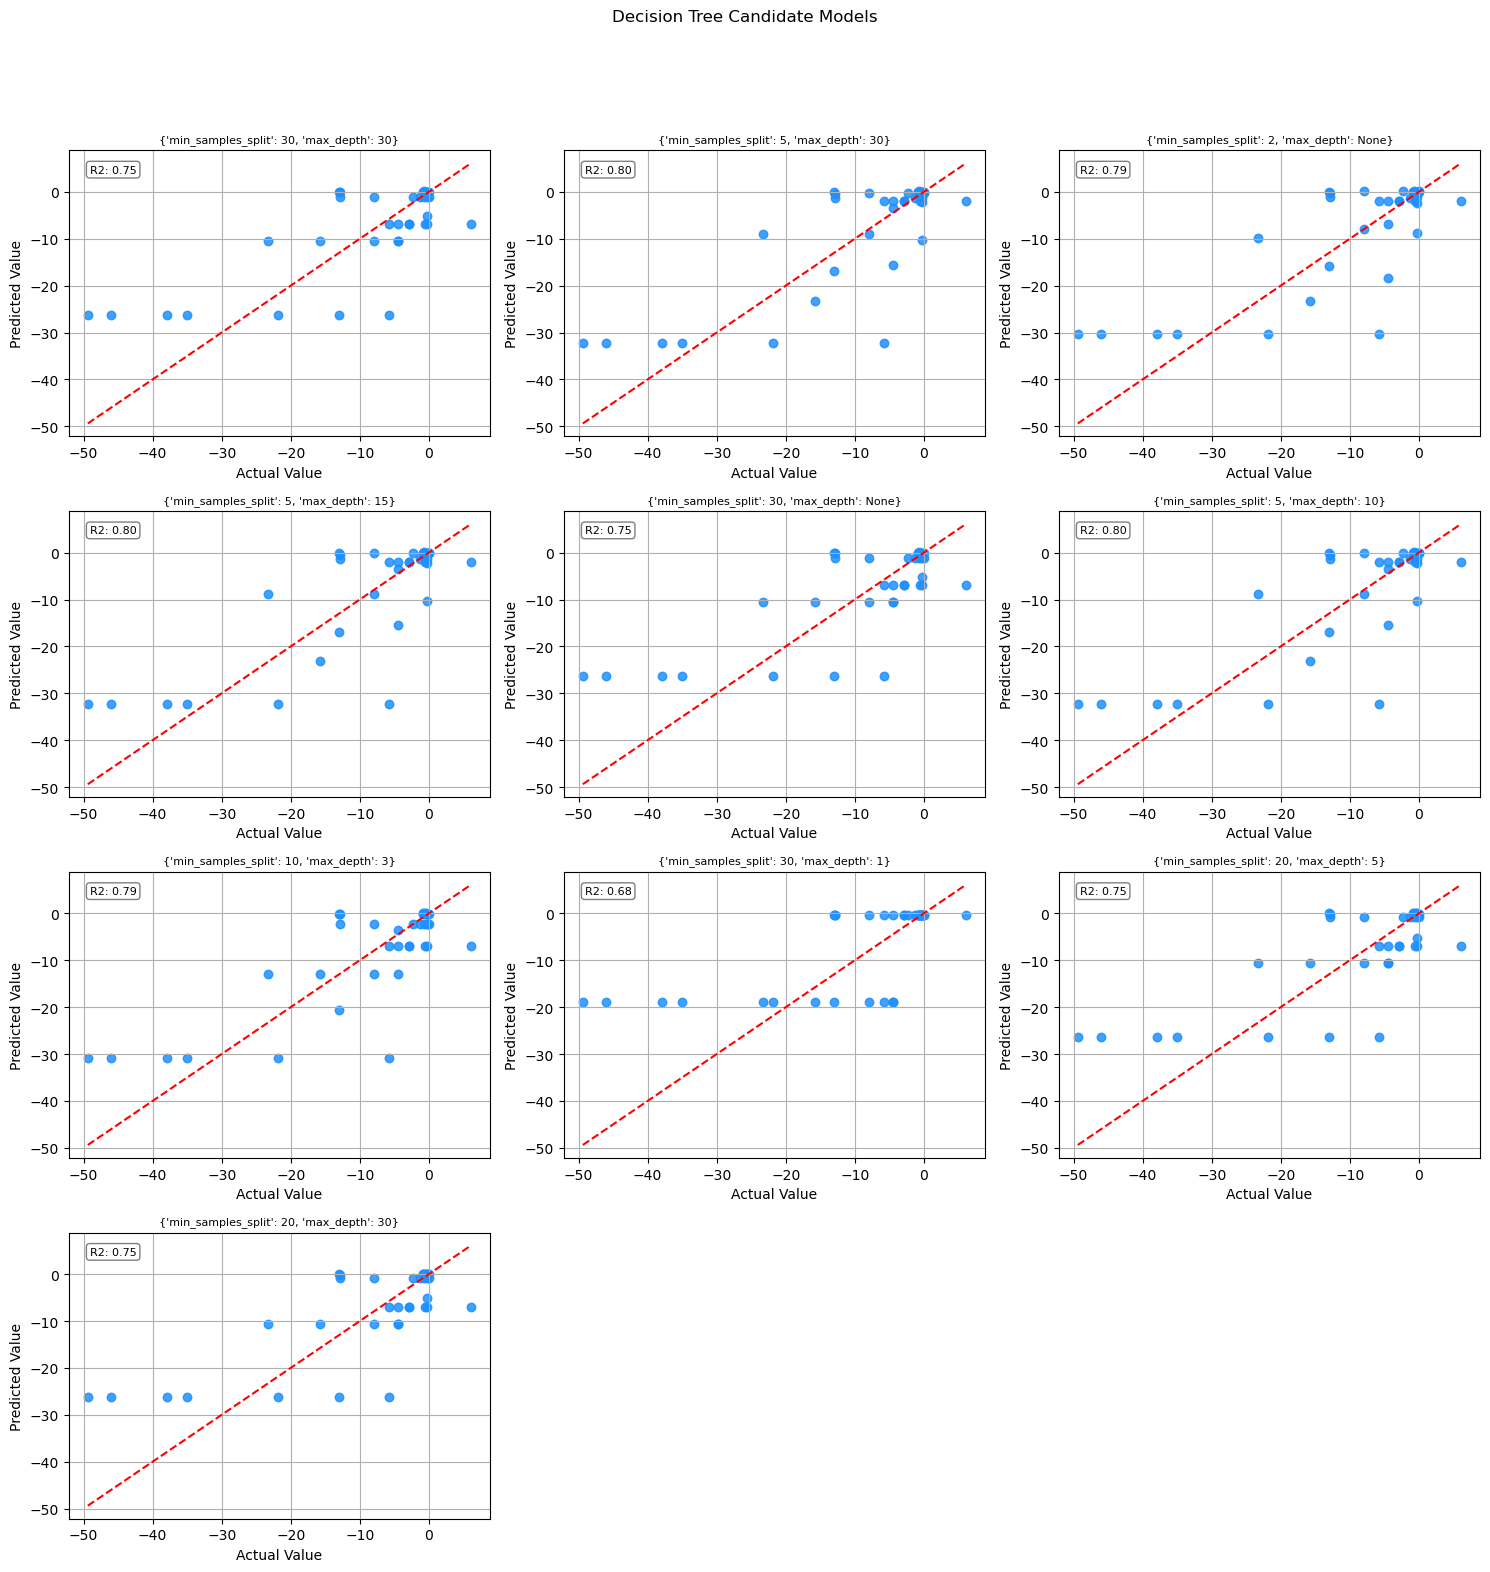

Evaluation and plotting completed for countries: ['FR']


In [19]:
# -----------------------------
# 6. Main Execution
# -----------------------------
# Load datasets
past_season_data = pd.read_csv('ILI_datasets/revisions_dataset_23_24.csv')
new_season_data = pd.read_csv('ILI_datasets/revisions_dataset_24_25.csv')

# List of countries to process
countries = ['FR']

# Dictionaries to store best and candidate results
results_dict = {}
y_tests = {}
y_preds_rf = {}
y_preds_dt = {}
rf_candidate_params_all = {}
rf_candidate_predictions_all = {}
dt_candidate_params_all = {}
dt_candidate_predictions_all = {}

for country in countries:
    results = train_and_evaluate(
        country,
        past_season_data[past_season_data['country'] == country],
        new_season_data[new_season_data['country'] == country],
        ['age', 'value'],
        'revision_amount'
    )
    results_dict[country] = results
    y_tests[country] = results["y_test"]
    y_preds_rf[country] = results["y_pred_rf"]
    y_preds_dt[country] = results["y_pred_dt"]
    rf_candidate_params_all[country] = results["rf_candidate_params"]
    rf_candidate_predictions_all[country] = results["rf_candidate_predictions"]
    dt_candidate_params_all[country] = results["dt_candidate_params"]
    dt_candidate_predictions_all[country] = results["dt_candidate_predictions"]

# Plot best models (RF and DT)
plot_best_models(countries, y_tests, y_preds_rf, y_preds_dt)

# For each country, plot candidate models for Random Forest and Decision Tree
for country in countries:
    if country in y_tests:
        y_test = y_tests[country]
        # Plot candidate models for Random Forest
        plot_candidate_models("Random Forest", rf_candidate_params_all[country],
                              rf_candidate_predictions_all[country], y_test)
        # Plot candidate models for Decision Tree
        plot_candidate_models("Decision Tree", dt_candidate_params_all[country],
                              dt_candidate_predictions_all[country], y_test)

print("Evaluation and plotting completed for countries:", countries)
